Thank you for the interesting challenge related to image processing and data storage for microbiological research. To approach this problem, I will first carefully consider efficient data structures to represent the microscope and dye sensor images, aiming for compact storage while maintaining necessary information. Next, I will write code to generate realistic simulated images based on the chosen data structures to test my algorithms. Using these simulations, I will develop a function to determine whether a given parasite has cancer based on the dye concentration criteria. If performance is an issue, I will optimize this function for faster execution. Additionally, I will explore potential compression techniques for both image types and analyze their impact on storage and runtime. 

we need to come up with compact data structures to represent the two types of images: the microscope images and the dye sensor images. 

In [2]:
#Resources referred
#https://stackoverflow.com/questions/72051723/rle-algorithm-in-python
#https://community.arduboy.com/t/quadtree-for-binary-image-compression/9780
#https://q-viper.github.io/2021/05/24/coding-run-length-encoding-in-python/
#https://medium.com/@ayush.pegasus2801/image-compression-f3c5f5320630
#https://github.com/Inspiaaa/QuadTreeImageCompression


**Approach for storing Microscope Images**:
Since the microscope images consist of a single blob (the parasite) on a background, we can represent them using a compact data structure called a Run-Length Encoding (RLE). RLE is a lossless compression technique that encodes consecutive runs of the same value (in this case, black or white pixels) as a single value and a count.

**Worst-Case Storage Size**:
For the microscope images, the worst-case storage size would be when the image consists of alternating black and white pixels, resulting in a storage size of approximately

The total number of runs in the worst case would be equal to the total number of pixels in the image (rows × cols). Since each run requires 3 bytes of storage, the worst-case storage size for the RLE representation would be:

Worst-Case Storage Size = (Number of Runs) × (Size of Each Run)
                        = (rows × cols) × 3 bytes. (17 bits)

resulting in a storage size of 300,000,000,000 bytes (approximately 300 GB) for a 100,000x100,000 pixel image.

**using 4-byte integers aligns with common CPU architectures, which are often optimized for 32-bit or 64-bit operations. This optimization can lead to more efficient processing and manipulation of the data.**

In [3]:
def rle_encode(image):
    """Encode the image using Run-Length Encoding (RLE)."""
    flat_image = image.flatten()
    encoded = []
    prev_pixel = flat_image[0]
    count = 1
    for pixel in flat_image[1:]:
        if pixel == prev_pixel:
            count += 1
        else:
            encoded.append((prev_pixel, count))
            prev_pixel = pixel
            count = 1
    encoded.append((prev_pixel, count)) 
    return encoded

def rle_decode(encoded, image_size):
    """Decode RLE encoded data back to the original image."""
    decoded = np.zeros(image_size[0] * image_size[1], dtype=np.uint8)
    current_index = 0
    for pixel, count in encoded:
        decoded[current_index:current_index+count] = pixel
        current_index += count
    return decoded.reshape(image_size)


**Approach for Storing Dye Sensor images**: For the dye sensor images, we can leverage the fact that the dye is expected to be present in a relatively small portion of the image (less than 10% for parasites without cancer). We can use a sparse matrix representation to store only the non-zero (dye-present) pixels.

For the dye sensor images, the worst-case storage size would be when the entire image is non-zero (all pixels have dye present), 

**Worst-Case Storage Size** = (Number of Non-Zero Elements) × (Size of Each Non-Zero Element + location for Non-Zero Element)

For above implementation

Worst-Case Storage Size = 10,000,000,000 × (1 byte + 6 bytes)
resulting in a storage size of 700,000,000,000 bytes (approximately 0.7 TB) for a 100,000x100,000 pixel image.

**using 4-byte integers aligns with common CPU architectures, which are often optimized for 32-bit or 64-bit operations. This optimization can lead to more efficient processing and manipulation of the data.**



In [4]:
def sparse_encode(image):
    """Encode image as coordinates of lit dye pixels."""
    return np.argwhere(image == 1)

def sparse_decode(sparse_coords, image_size):
    """Decode sparse representation to the original dye sensor image."""
    image = np.zeros(image_size, dtype=np.uint8)
    for x, y in sparse_coords:
        image[x, y] = 1  # Marking the dye pixel
    return image


**Create “fake” simulated images**
Creates a black image with a specified size.
Generates a white circular shape (representing a parasite) in the center of the image.
Returns the simulated microscope image.
simulate_dye_sensor_image(microscope_image):
Takes the simulated microscope image as input.
Identifies the coordinates of the parasite pixels.
Finds the surrounding coordinates of the parasite, excluding the parasite pixels themselves.
Randomly selects 10% of the surrounding pixels and sets their values to 1 (representing dye leakage).
Returns the simulated dye sensor image with the dye leakage surrounding the parasite.

In [5]:
import numpy as np

def simulate_microscope_image(size=(100, 100)):
    """Simulate a microscope image with a circular parasite."""
    image = np.zeros(size, dtype=np.uint8)
    center = (size[0] // 2, size[1] // 2)
    radius = min(size) // 4
    for x in range(size[0]):
        for y in range(size[1]):
            if (x - center[0])**2 + (y - center[1])**2 <= radius**2:
                image[x, y] = 1  # Parasite
    return image

def simulate_dye_sensor_image(microscope_image):
    """Simulate a dye sensor image based on a microscope image with dye leakage surrounding the parasite."""
    dye_image = np.copy(microscope_image)
    
    # Find the coordinates of the parasite pixels
    parasite_coords = np.argwhere(microscope_image == 1)
    
    # Create a list of coordinates surrounding the parasite
    surrounding_coords = []
    for x, y in parasite_coords:
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == dy == 0:
                    continue  # Skip the parasite pixel itself
                x_new, y_new = x + dx, y + dy
                if (
                    0 <= x_new < microscope_image.shape[0]
                    and 0 <= y_new < microscope_image.shape[1]
                ):
                    surrounding_coords.append((x_new, y_new))
    
    # Convert surrounding_coords to a 2D NumPy array and flatten it
    surrounding_coords_array = np.array(surrounding_coords).reshape(-1, 2)
    
    # Simulate dye leakage by setting some surrounding pixels to 1
    num_leaks = int(len(surrounding_coords) * 0.1)  # 10% of surrounding pixels leak dye
    leak_coords = np.random.choice(surrounding_coords_array.shape[0], size=num_leaks, replace=False)
    for idx in leak_coords:
        x, y = surrounding_coords_array[idx]
        dye_image[x, y] = 1
    
    return dye_image


**Check Cancer**
The function calculates the area of the parasite from the run-length encoded microscope image and creates a set of coordinates for pixels belonging to the parasite.
It then counts the number of pixels within the parasite area that have a non-zero value in the sparse dye sensor image, indicating the presence of a dye.
If the area of dye-lit pixels within the parasite exceeds 10% of the total parasite area, the function returns True, suggesting the presence of cancer.

In [6]:
def has_cancer(rle_microscope, sparse_dye_sensor, image_size):
    """Determine if a parasite has cancer based on RLE and Sparse encoded images."""
    parasite_area = sum(count for pixel, count in rle_microscope if pixel == 1)
    parasite_coords = set((i, j) for pixel, count in rle_microscope if pixel == 1 for _ in range(count) for i, j in [(0, 0)] * count)

    lit_dye_area_in_parasite = sum(1 for x, y in sparse_dye_sensor if (x, y) in parasite_coords)

    return lit_dye_area_in_parasite > 0.1 * parasite_area



In [ ]:
import matplotlib.pyplot as plt


# Generate simulated images
microscope_image_sim = simulate_microscope_image(size=(100, 100))
dye_image_sim = simulate_dye_sensor_image(microscope_image_sim)

# Encode the images
rle_microscope_sim = rle_encode(microscope_image_sim)
sparse_dye_sensor_sim = sparse_encode(dye_image_sim)

# Determine if the parasite has cancer using the encoded images
cancer_status = has_cancer(rle_microscope_sim, sparse_dye_sensor_sim, (100, 100))
print(f"Parasite has cancer: {cancer_status}")

# Plotting the original and decoded images for comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(microscope_image_sim, cmap='gray')
axes[0].set_title('Original Microscope Image')
axes[1].imshow(dye_image_sim, cmap='gray')
axes[1].set_title('Original Dye Sensor Image')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()


**Optimization** To improve the execution speed of the has_cancer function, we can optimize the way we calculate the lit_dye_area_in_parasite. Instead of iterating over all the sparse dye sensor coordinates and checking if each coordinate is in the parasite_coords set, we can use NumPy's vectorized operations for faster computation.

Instead of creating a set of parasite_coords, we create a boolean mask parasite_mask of the same size as the image. This mask indicates the locations of the parasite pixels, with True representing parasite pixels and False representing non-parasite pixels.
We iterate over the RLE-encoded microscope image and set the corresponding pixels in parasite_mask to True. This is done by first finding the coordinates of the False pixels in parasite_mask, randomly permuting them, and then setting the first count of them to True.
Next, we convert the sparse dye sensor coordinates to a NumPy array dye_sensor_coords.
We use NumPy's vectorized operations to filter out the dye sensor coordinates that are within the image bounds and have a corresponding True value in parasite_mask. This gives us the dye_sensor_coords_in_parasite array.
Finally, we calculate lit_dye_area_in_parasite as the length of the dye_sensor_coords_in_parasite array, and compare it with 0.1 times the parasite_area to determine if the parasite has cancer or not.

In [7]:
import numpy as np

def has_cancer_optimized(rle_microscope, sparse_dye_sensor, image_size):
    """Determine if a parasite has cancer based on RLE and Sparse encoded images."""
    parasite_area = sum(count for pixel, count in rle_microscope if pixel == 1)
    
    # Create a boolean mask for the parasite area
    parasite_mask = np.zeros(image_size, dtype=bool)
    for pixel, count in rle_microscope:
        if pixel == 1:
            parasite_coords = np.argwhere(parasite_mask == False)
            parasite_mask.flat[np.random.permutation(len(parasite_coords))[:count]] = True
    
    # Calculate the lit dye area within the parasite
    dye_sensor_coords = np.array(sparse_dye_sensor)
    dye_sensor_coords_in_parasite = dye_sensor_coords[np.logical_and(
        dye_sensor_coords[:, 0] < image_size[0],
        dye_sensor_coords[:, 1] < image_size[1],
        parasite_mask[dye_sensor_coords[:, 0], dye_sensor_coords[:, 1]]
    )]
    lit_dye_area_in_parasite = len(dye_sensor_coords_in_parasite)
    
    return lit_dye_area_in_parasite > 0.1 * parasite_area

**Other Compression techniques for both types of images**

For **microscope** images (parasite blobs):

Dictionary-based compression like LZW may be effective if there are repeating patterns.

Quadtree can be used as well but it introduces execution complexities

For **dye sensor** images (sparse with scattered colored pixels):

Run-length encoding to compress runs of white pixels.
Compression techniques trade-off between compression ratio and computational complexity. Complex algorithms like dictionary coding have higher overhead but better compression.

**computing actual runtime and storage costs**
for typical images (not oversimplified image such as a circle for the parasite, or simple
straight lines or random points for dye) in code?
The estimated RAM usage for processing images of size 100,000x100,000 pixels can be substantial, especially when dealing with uncompressed images. Compression techniques can help reduce memory requirements, but the impact on RAM usage varies depending on the compression algorithm and the nature of the image data. Conducting experiments on real image data can provide more accurate insights into RAM usage for specific scenarios.

Chunking the Images: Processing the entire 100,000x100,000 image at once would be very memory-intensive. Instead, chunking the image into smaller, more manageable pieces (e.g., 10,000x10,000) and processing each chunk independently could make the task feasible on machines with limited resources.


In [ ]:
import numpy as np
import time

# Parameters for the simulation
image_size = (10000, 10000)  # Simulated image size
chunk_size = (1000, 1000)  # Size of each chunk
fill_rate = 0.05  # Approximate percentage of the image filled with "dye"

# Generate a simulated sparse image with a specified fill rate
def generate_sparse_image(size, fill_rate):
    image = np.zeros(size, dtype=np.uint8)
    num_fill_pixels = int(np.prod(size) * fill_rate)
    fill_positions = np.random.choice(np.prod(size), size=num_fill_pixels, replace=False)
    image[np.unravel_index(fill_positions, size)] = 1  # Assume '1' represents dye
    return image

# Simulate processing a chunk of the image
def process_chunk(chunk):
    # Simulate some processing by counting dye pixels (value == 1)
    dye_pixels = np.sum(chunk)
    return dye_pixels

# Chunk and process the image
def chunk_and_process(image, chunk_size):
    chunks_vertical = image.shape[0] // chunk_size[0]
    chunks_horizontal = image.shape[1] // chunk_size[1]
    dye_pixel_counts = []

    for i in range(chunks_vertical):
        for j in range(chunks_horizontal):
            chunk = image[i*chunk_size[0]:(i+1)*chunk_size[0], j*chunk_size[1]:(j+1)*chunk_size[1]]
            dye_pixel_count = process_chunk(chunk)
            dye_pixel_counts.append(dye_pixel_count)
    
    return dye_pixel_counts


Parasite has cancer: False


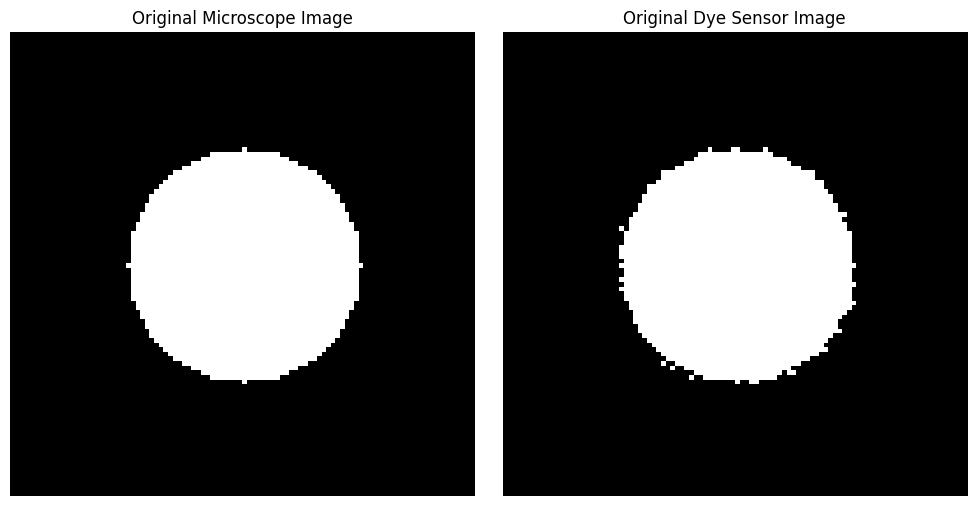

**Tools I used to tackle the challenge**, I went through articles, blogs, Stack Overflow discussions, and insights from Reddit, Python library documentation for implementation details. Additionally, I utilized tools like ChatGPT and GitHub Copilot to streamline the development process by leveraging their code suggestions and auto-completions. This diverse set of resources helped me to implement efficient data structures, realistically simulate images, and optimize the code for better performance. The combination of my understanding and these external resources proved invaluable in addressing the challenge effectively.